# 1. Description

Test `Surprise` library for recomendation system, create 2-step recommendation system based on Amazon `sport and outdoor` [dataset (small)](https://nijianmo.github.io/amazon/index.html).

Sports and Outdoors dataset:   
* overall - rating of the product
* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* reviewTime - time of the review (raw)
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* reviewText - text of the review
* summary - summary of the review
* unixReviewTime - time of the review (unix time)

# 2. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.stats import uniform, randint


import matplotlib.pyplot as plt

import surprise
from surprise.model_selection.split import train_test_split

import time
import json
import copy
from collections import defaultdict

from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from gensim.models import Word2Vec

C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
from scripts import get_top_n, create_id_specific_features, get_embedding

# 3. Global params

In [2]:
SEED = 42
TEST_RATIO = 0.2
RAITING = "overall"
CONFIDENCE = "vote"
USER_ID = "reviewerID"
ITEM_ID = "asin"
RAITING_CONFIDENCE = "raiting_confidence"
DATA_FOLDER = "./data/"

# To be shure to have enought known users in test dataset
CRITICAL_KNOWN_USERS = 0.6
CRITICAL_KNOWN_ITEMS = 0.8
CV = 5
METRICS = ["RMSE", "MAE"]
KEY_METRIC = "mae"
KEY_METRIC_SK ="neg_mean_absolute_error"
SHUFFLE = True
NUM_ITER = 10

# For second algo
VECTOR_SIZE = 20
NUM_ITER_SC = 10

REC_COL = "recom"
REC_RF_COL = REC_COL + "_rf"
VEC_COL = "summary"
BOOL_COL = "verified"
TRAIN_COLS = [VEC_COL, BOOL_COL, "unixReviewTime", "review_count", "raiting_confidence", REC_COL]

# 4. Download data

Download https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Sports_and_Outdoors_5.json.gz into ./data

In [3]:
data = [json.loads(line) for line in open(DATA_FOLDER + 'Sports_and_Outdoors_5.json', 'r')]
df_data_raw = pd.DataFrame(data)
df_data_raw['vote'] = df_data_raw['vote'].str.replace(",", "")
df_data_raw.sort_values("unixReviewTime", inplace=True)

General info about uploading data

In [4]:
print(df_data_raw.shape)
df_data_raw.info(verbose = False)

(2839940, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 2839940 entries, 2491 to 2839882
Columns: 12 entries, overall to image
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 262.7+ MB


# 2. EDA

In [5]:
df_data_proc = df_data_raw.copy()
df_data_proc.sample(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
778113,4.0,True,"09 20, 2016",AHBWXNMC1GZBZ,B001QBHT1K,mila jose,Came in earlier than expected. Everything int...,Decided on this brand because in my recent vac...,1474329600,"{'Size:': ' Medium (Ladies 8-11)', 'Color:': '...",NaN,NaN
1145779,5.0,True,"05 3, 2015",ANT0G0B58SBQU,B0057XLC2U,David C. Goetz,"Great hat for drizzly days, and on sunny days-...",Great hat for drizzly days,1430611200,{'Color:': ' Realtree Xtra'},NaN,NaN
623406,5.0,True,"11 7, 2015",A1JAA953O9VPMQ,B0019GJZE6,chale&#039;32,Getting good use of it for batting practice,I call it my thunder stick,1446854400,{'Color:': ' Power Stick'},NaN,NaN
459791,4.0,True,"10 13, 2011",A35O7ULF81HYU2,B0017S37UY,Jason,Stayed plenty warm on a 40 degree night in a V...,Plenty warm for most,1318464000,"{'Color:': ' Canvas/ Tan', 'Style:': ' +25 Deg...",8,NaN
103745,5.0,True,"01 7, 2015",ALDDDFMURJUY9,B000BSWE9Q,Daniel,Not full tang but still a good knife and mildl...,Five Stars,1420588800,NaN,NaN,NaN


Firstly check `Null` in `overall`, `reviewerID`, `asin`. There are no `Null`s. It is noted `reviewerID` and `asin` are objects.

In [6]:
df_data_proc.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2839940 entries, 2491 to 2839882
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         2839940 non-null  float64
 1   verified        2839940 non-null  bool   
 2   reviewTime      2839940 non-null  object 
 3   reviewerID      2839940 non-null  object 
 4   asin            2839940 non-null  object 
 5   reviewerName    2839661 non-null  object 
 6   reviewText      2838826 non-null  object 
 7   summary         2839329 non-null  object 
 8   unixReviewTime  2839940 non-null  int64  
 9   style           1597168 non-null  object 
 10  vote            378880 non-null   object 
 11  image           64535 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 262.7+ MB


In [7]:
# Make RAITING int and vote float
print(df_data_proc[RAITING].unique())

df_data_types = {RAITING: 'int',
                 'vote': 'float32'}

df_data_proc = df_data_proc.astype(df_data_types)

[5. 4. 2. 1. 3.]


Create feature with reviews count for the same item from the same user.

In [8]:
df_data_proc['review_count'] = df_data_proc.groupby([USER_ID, ITEM_ID])[RAITING].transform('count')

Delete repeated reviews and save the freshest.

In [9]:
df_data_proc = df_data_proc[~df_data_proc.duplicated([USER_ID, ITEM_ID], keep="last")]
print(f"Deleted reviews from the same user and the same item {100 * (df_data_raw.shape[0] - df_data_proc.shape[0]) / df_data_raw.shape[0]:.2f} %")

Deleted reviews from the same user and the same item 5.65 %


In [10]:
display(df_data_proc[[USER_ID, ITEM_ID]].nunique())
print("Share of unique users and items, %")
display(100 * round(df_data_proc[[USER_ID, ITEM_ID]].nunique() / df_data_proc.shape[0], 2))

reviewerID    332447
asin          104687
dtype: int64

Share of unique users and items, %


reviewerID    12.0
asin           4.0
dtype: float64

1. Raiting distribution in %


<Axes: >

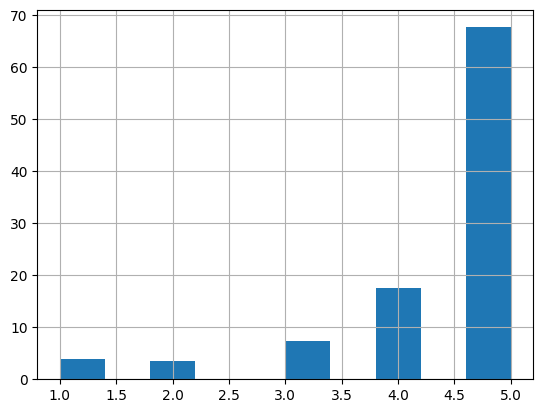

In [11]:
print("1. Raiting distribution in %")
df_data_proc[RAITING].hist(bins=10,
                           weights=np.ones_like(df_data_proc[df_data_proc.columns[0]]) * 100. / len(df_data_proc),)

2. Raiting distribution by items


overall  mean    4.371706
         std     0.914599
dtype: float64

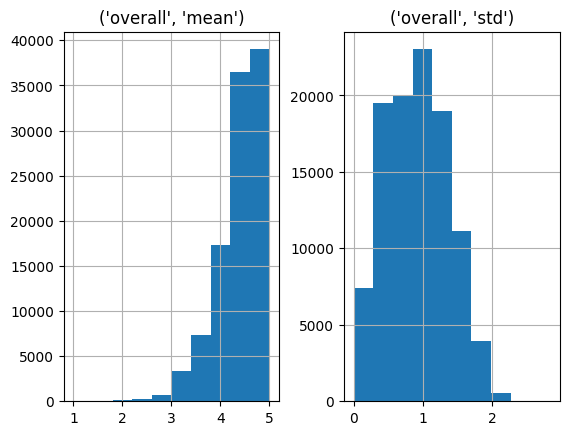

In [12]:
print("2. Raiting distribution by items")
df_data_proc[[RAITING, ITEM_ID]].groupby(ITEM_ID).agg(["mean", "std"]).hist(bins=10,)
display(df_data_proc[[RAITING, ITEM_ID]].groupby(ITEM_ID).agg(["mean", "std"]).mean())

3. Raiting distribution by users


overall  mean    4.397208
         std     0.747022
dtype: float64

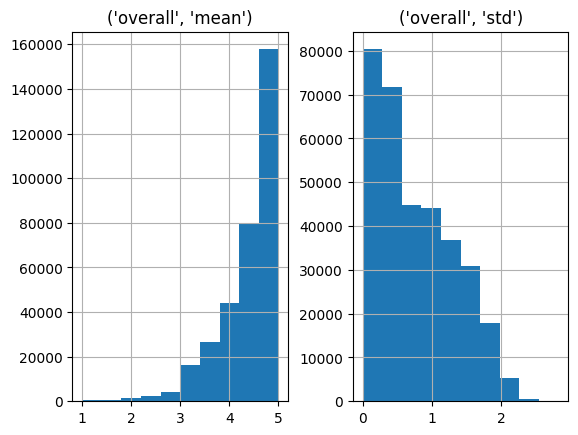

In [13]:
print("3. Raiting distribution by users")
df_data_proc[[RAITING, USER_ID]].groupby(USER_ID).agg(["mean", "std"]).hist(bins=10)
display(df_data_proc[[RAITING, USER_ID]].groupby(USER_ID).agg(["mean", "std"]).mean())

5. Vote distribution in %


<Axes: >

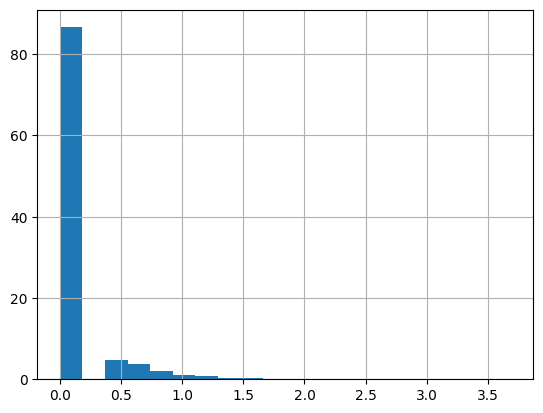

In [14]:
# Prepare vote column: replace nan's and add 1 as the raiting itself is a vote
df_data_proc['vote'] = df_data_proc['vote'].fillna(0) + 1
print("5. Vote distribution in %")
np.log10(df_data_proc['vote']).hist(bins=20,
                                    weights=np.ones_like(df_data_proc['vote']) * 100. / len(df_data_proc['vote']))

6. Raiting taking into account number of votes


<Axes: >

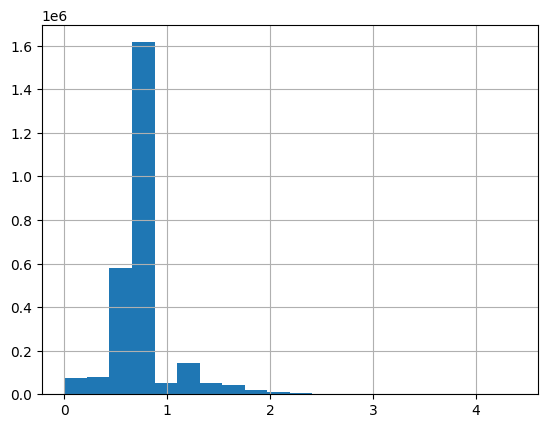

In [15]:
# Create new feature with vote in it. The idea is that vote close to raiting - people agree with the raiting and review, therefore rating itself have it's strength depending on vote.
# vote is right-skewed, therefore take a logarithm
df_data_proc[RAITING_CONFIDENCE] = np.log10(df_data_proc['vote'] * df_data_proc[RAITING])
# transfer raiting to 1->5
print("6. Raiting taking into account number of votes")
df_data_proc[RAITING_CONFIDENCE].hist(bins=20)

7. Number of user reviews


<Axes: >

reviewerID
AMMU9VZZ9OSII     12
A17KNKWCU3VQCC    24
A35D2NA4PFKOD1    25
A34V0ZVT9KVPZM    12
A1IAZV9G9TSR7E    18
A2EUH5XN2FKHC3    41
A2OO9W1MFAFGWY    27
A3UNPH6U0A65SW    14
AFF1RE25JNEGP     16
A1K93O68KBD1LE    17
A3AVWE26TRE35Y    24
A24B2CJOB0SPLC    11
A3PFLC5GUZRILE    21
A3EAD2KKE9K7X5    11
AV8Y6HRKXCKN8     18
A2R8LAC7FDNGTT    14
A2VIC01SZ9X9CI    15
A1TRN925NZIODW    12
A1ZQ5PM6TKDGGP    12
A3MFU0GVZUVH3K    20
Name: asin, dtype: int64

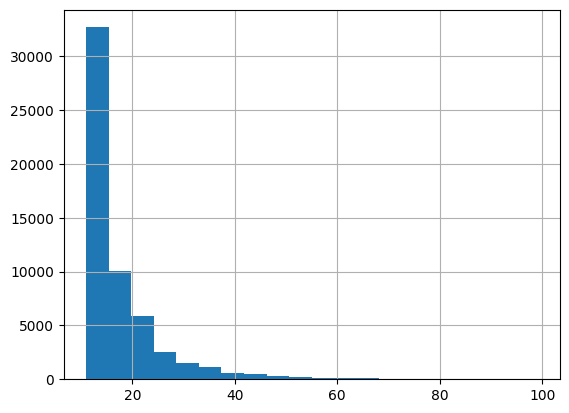

In [16]:
users_cnt = df_data_proc.groupby(USER_ID).count()[ITEM_ID].sort_values(ascending=False)
users_cnt = users_cnt[users_cnt.apply(lambda x: (x>10) and (x<100))]

print("7. Number of user reviews")
display(users_cnt.hist(bins=20))
users_cnt.sample(20, random_state=SEED)

### Estimate sparsity

In [17]:
# Fix unique vals reviewerName
users_all = {row[USER_ID]: row['reviewerName'] for (_, row) in df_data_proc.drop_duplicates(subset=[USER_ID])[[USER_ID, 'reviewerName']].iterrows()}
items_all = df_data_proc[ITEM_ID].unique()

# Get codes from object types
rows = df_data_proc[USER_ID].astype('category').cat.codes 
cols = df_data_proc[ITEM_ID].astype('category').cat.codes

# Save data in sparse format
df_data_sparse = sparse.csr_matrix((df_data_proc[RAITING], (rows, cols)), shape=(len(users_all), len(items_all)))

# Number of possible interactions in the matrix
matrix_size = df_data_sparse.shape[0] * df_data_sparse.shape[1]
# Number of items interacted with
num_reviews = len(df_data_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_reviews / matrix_size))

print(f"Degree of sparsity: {sparsity:.3f}%")

Degree of sparsity: 99.992%


Total:
* 70% raitings - 5
* Mean item raiting 4,37 +- 0,91
* Mean user raiting 4,40 +- 0,75
* High sparsity degree 99,992%   


Observed, users are aimed to give close raitings (less spread and it is seen in distribution form). All distributions are asymmetric, closer to 5. Have tried to fix distribution by quantile_transfor and power transformation, which not succeed. Whereas syntetic raiting with votes number in account with log transformation has distribution is closer to normal (but the principle is not reflect explicit rating):
* New raiting was tested
* Data transformation was used to have normal distribution

### Prepare data

In [21]:
reader = surprise.Reader(line_format='user item rating', rating_scale=(1, 5))
dataset = surprise.Dataset.load_from_df(df_data_proc[[USER_ID, ITEM_ID, RAITING]], reader)

# 3. Train-test split

### Full dataset

In [22]:
# Dataset sorted, therefore testset is future
raw_ratings = dataset.raw_ratings

TRESHOLD = int((1 - TEST_RATIO) * len(raw_ratings))
train_raw_ratings = raw_ratings[:TRESHOLD]
test_raw_ratings = raw_ratings[TRESHOLD:]

dataset.raw_ratings = train_raw_ratings  # data is now is train
testset = dataset.construct_testset(test_raw_ratings) # testset

### Short dataset (for RAM extensive algos)

In [41]:
# Short dataset for debug and for Slope One and kNN (do not enough RAM for train)
short_dataset_tresh = int(0.98 * len(train_raw_ratings))
dataset_short = copy.deepcopy(dataset)
dataset_short.raw_ratings = train_raw_ratings[short_dataset_tresh:]  # data is now is train

### Explore known users and items in test dataset

In [22]:
known_users = set(dataset.df[USER_ID].iloc[:TRESHOLD]) & set(dataset.df[USER_ID].iloc[TRESHOLD:])
train_users = set(dataset.df[USER_ID].iloc[:TRESHOLD])
unknown_users = set(dataset.df[USER_ID].iloc[TRESHOLD:][~dataset.df[USER_ID].iloc[TRESHOLD:].isin(known_users)])

portion_known_users = dataset.df[USER_ID].iloc[TRESHOLD:].isin(known_users).sum() / len(test_raw_ratings)
assert portion_known_users > CRITICAL_KNOWN_USERS
print(f"Known users in test dataset {100 * portion_known_users:.2f}%")

Known users in test dataset 77.89%


In [23]:
known_items = set(dataset.df[ITEM_ID].iloc[:TRESHOLD]) & set(dataset.df[ITEM_ID].iloc[TRESHOLD:])
train_items = set(dataset.df[ITEM_ID].iloc[:TRESHOLD])
unknown_items = set(dataset.df[ITEM_ID].iloc[TRESHOLD:][~dataset.df[ITEM_ID].iloc[TRESHOLD:].isin(known_items)])

portion_known_items = dataset.df[ITEM_ID].iloc[TRESHOLD:].isin(known_items).sum() / len(test_raw_ratings)
assert portion_known_items > CRITICAL_KNOWN_ITEMS
print(f"Known users in test dataset {100 * portion_known_items:.2f}%")

Known users in test dataset 98.01%


### Prepare cv

In [24]:
cv_algo = surprise.model_selection.split.KFold(n_splits=CV, random_state=SEED, shuffle=SHUFFLE,)

In [25]:
# DO NOT WORK WITH GridSearch https://datascience.stackexchange.com/questions/73583/how-to-train-test-split-and-cross-validate-in-surprise

# Dataset sorted, therefore testset is future
# trainset, testset = train_test_split(dataset, test_size=TEST_RATIO, random_state=SEED, shuffle=False)

# known_users = 0
# for (user, _, _) in testset:
#     try:
#         known_users += int(trainset.knows_user(trainset.to_inner_uid(user)))
#     except ValueError:
#         continue

# portion_known_users = known_users / len(testset)
# assert portion_known_users > CRITICAL_KNOWN_USERS
# print(f"Known users in test dataset {100 * portion_known_users:.2f}%")

# 4. Baseline

In [26]:
base_model = surprise.BaselineOnly()

In [27]:
%%time

base_model_cv_res = surprise.model_selection.cross_validate(base_model,
                                                            dataset,
                                                            measures=METRICS,
                                                            cv=cv_algo,
                                                            verbose=True,)
base_model_cv_res

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9606  0.9627  0.9627  0.9626  0.9631  0.9623  0.0009  
MAE (testset)     0.6996  0.7009  0.7014  0.7001  0.7011  0.7006  0.0007  
Fit time          7.37    7.75    9.10    10.24   8.70    8.63    1.02    
Test time         2.61    5.09    2.61    2.51    5.03    3.57    1.22    
CPU times: total: 1min 50s
Wall time: 1min 50s


{'test_rmse': array([0.96062517, 0.9626823 , 0.96266178, 0.96264235, 0.96312309]),
 'test_mae': array([0.69959357, 0.70090402, 0.7014176 , 0.70011275, 0.70107799]),
 'fit_time': (7.36521315574646,
  7.747415065765381,
  9.097707271575928,
  10.239163398742676,
  8.701039791107178),
 'test_time': (2.6066136360168457,
  5.091938018798828,
  2.6089529991149902,
  2.505314588546753,
  5.030181407928467)}

In [28]:
predictions = base_model.test(testset)
base_model_metrics = (surprise.accuracy.rmse(predictions), surprise.accuracy.mae(predictions))

RMSE: 1.0396
MAE:  0.7509


# 4. Other models

### Slope One

In [29]:
%%time

so1 = surprise.SlopeOne()
so1_cv_res = surprise.model_selection.cross_validate(so1,
                                                     dataset_short,
                                                     measures=METRICS,
                                                     cv=cv_algo,
                                                     verbose=True)
so1_cv_res

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0506  1.0498  1.0468  1.0331  1.0466  1.0454  0.0064  
MAE (testset)     0.6934  0.6915  0.6905  0.6844  0.6890  0.6897  0.0031  
Fit time          5.93    7.26    5.63    7.29    5.55    6.33    0.78    
Test time         0.11    0.12    0.13    0.12    0.13    0.12    0.01    
CPU times: total: 33 s
Wall time: 33.1 s


{'test_rmse': array([1.05058392, 1.04980449, 1.04680794, 1.03306071, 1.04657429]),
 'test_mae': array([0.69337924, 0.69151217, 0.69047481, 0.68435262, 0.68898127]),
 'fit_time': (5.927400588989258,
  7.260566473007202,
  5.625110149383545,
  7.292251348495483,
  5.546650648117065),
 'test_time': (0.1050412654876709,
  0.11658573150634766,
  0.13222622871398926,
  0.12032175064086914,
  0.12601590156555176)}

In [31]:
predictions = so1.test(testset)
so1_metrics = (surprise.accuracy.rmse(predictions), surprise.accuracy.mae(predictions))

RMSE: 1.0922
MAE:  0.7988


### SVD++

In [32]:
%%time
param_grid = {'n_factors': [4, 6, 10, 14], # randint(4, 40),
              'n_epochs': [5, 10, 15], # np.power(10, np.arange(1, 2, 0.1)).astype(int),
              'lr_all': [0.001, 0.01], # np.power(5, np.arange(-5, 1, 0.5)),
              'reg_all': [2, 1, 0.1, 0.01], # np.power(5, np.arange(-5, 1, 0.5)),
              'random_state': [SEED, ]}

gs_svdpp = surprise.model_selection.RandomizedSearchCV(surprise.SVDpp,
                                                       param_grid,
                                                       n_iter=NUM_ITER,
                                                       measures=METRICS,
                                                       cv=cv_algo,
                                                       random_state=SEED)
gs_svdpp.fit(dataset)

display(vars(gs_svdpp.best_estimator[KEY_METRIC]))
print(gs_svdpp.best_score[KEY_METRIC])

{'n_factors': 6,
 'n_epochs': 15,
 'init_mean': 0,
 'init_std_dev': 0.1,
 'lr_bu': 0.01,
 'lr_bi': 0.01,
 'lr_pu': 0.01,
 'lr_qi': 0.01,
 'lr_yj': 0.01,
 'reg_bu': 0.01,
 'reg_bi': 0.01,
 'reg_pu': 0.01,
 'reg_qi': 0.01,
 'reg_yj': 0.01,
 'random_state': 42,
 'verbose': False,
 'cache_ratings': False,
 'bsl_options': {},
 'sim_options': {'user_based': True}}

0.6636935569356539
CPU times: total: 23min 44s
Wall time: 23min 45s


In [34]:
%%time

svdpp = gs_svdpp.best_estimator[KEY_METRIC]
svdpp.fit(dataset.build_full_trainset())
predictions = svdpp.test(testset)
svdpp_metrics = (surprise.accuracy.rmse(predictions), surprise.accuracy.mae(predictions))

RMSE: 1.0383
MAE:  0.7270
CPU times: total: 46.5 s
Wall time: 46.5 s


### KNN

In [42]:
%%time

param_grid = {'k': [5, 10, 20, 30, 50],
              'min_k': [3, 5, 10, 15], 
              'sim_options': {
                  'name': ['cosine', 'pearson', 'msd',],
                  'user_based': [True, ]
                  }
             }

gs_knn = surprise.model_selection.RandomizedSearchCV(surprise.KNNBaseline,
                                                     param_grid,
                                                     n_iter=NUM_ITER,
                                                     measures=METRICS,
                                                     cv=cv_algo,
                                                     random_state=SEED)
gs_knn.fit(dataset_short)


display(vars(gs_knn.best_estimator[KEY_METRIC]))
print(gs_knn.best_score[KEY_METRIC])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

{'bsl_options': {},
 'sim_options': {'name': 'msd', 'user_based': True},
 'verbose': True,
 'k': 20,
 'min_k': 5}

0.725661251367856
CPU times: total: 4min 2s
Wall time: 4min 2s


In [43]:
%%time

knn = gs_knn.best_estimator[KEY_METRIC]
knn.fit(dataset_short.build_full_trainset())
predictions = knn.test(testset)
knn_metrics = (surprise.accuracy.rmse(predictions), surprise.accuracy.mae(predictions))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0712
MAE:  0.7897
CPU times: total: 14.1 s
Wall time: 14.1 s


# 5. Outcome

In [44]:
surprise_metrics = pd.DataFrame([base_model_metrics, svdpp_metrics, so1_metrics, knn_metrics],
                                columns=["RMSE", "MAE"],
                                index=["BaselineOnly", "SVDpp", "SlopeOne", "KNNBaseline"])
surprise_metrics.sort_values(by=["MAE"])

,RMSE,MAE
SVDpp,1.038320,0.726963
BaselineOnly,1.039610,0.750934
KNNBaseline,1.071190,0.789666
SlopeOne,1.092173,0.798785


The best one is `SVDpp`. Whereas `KNNBaseline` and `SlopeOne` required more RAM (>32 Gb) for traiing. Therefore dataset was shortened.

# 6. Observe results

In [46]:
best_model = gs_svdpp.best_estimator[KEY_METRIC]
best_model.fit(dataset.build_full_trainset())

### Predict some items for specific user

In [47]:
# Отзывы user
users_test = {
    "A2EUH5XN2FKHC3": ["B00HVQT8WW", "B0017SGUDU", "B007PPI9JC", "B005I5ML0O"], # last item is unknown for user
    "AMMU9VZZ9OSII": ["B005I5ML0O", "B000VHTUKS", "B002060PBQ", "B007PPI9JC"],  # last item is unknown for user
    "A38VV9LBC1N11Z": ["B0014VYT7O", "B00T6PTQ6Y" , "B01CTPUQW0", "B01H1TXCJS"], # last 2 items i
} 

for user in users_test:
    display(df_data_proc[df_data_proc[USER_ID] == user][[USER_ID, ITEM_ID, RAITING]].sort_values(RAITING, ascending=False).head(3))
    display(df_data_proc[df_data_proc[USER_ID] == user][[USER_ID, ITEM_ID, RAITING]].sort_values(RAITING, ascending=False).tail(3))

,reviewerID,asin,overall
879378,A2EUH5XN2FKHC3,B002MD01MU,5
1386086,A2EUH5XN2FKHC3,B0095D3I8E,5
1544513,A2EUH5XN2FKHC3,B00CIOGI3E,5


,reviewerID,asin,overall
2555607,A2EUH5XN2FKHC3,B001GSMUCQ,3
700781,A2EUH5XN2FKHC3,B001FCFK5C,2
1319670,A2EUH5XN2FKHC3,B007PPI9JC,1


,reviewerID,asin,overall
1103380,AMMU9VZZ9OSII,B004WGN1KO,5
1181990,AMMU9VZZ9OSII,B005I5ML0O,5
418132,AMMU9VZZ9OSII,B0015KG5NK,5


,reviewerID,asin,overall
316162,AMMU9VZZ9OSII,B000VHTUKS,3
2325813,AMMU9VZZ9OSII,B018L2WM86,3
2571057,AMMU9VZZ9OSII,B002060PBQ,2


,reviewerID,asin,overall
556137,A38VV9LBC1N11Z,B0014VYT7O,5
1354193,A38VV9LBC1N11Z,B008CPU4CY,5
2306885,A38VV9LBC1N11Z,B017O9DLQY,5


,reviewerID,asin,overall
2480688,A38VV9LBC1N11Z,B01GW2H430,4
1829434,A38VV9LBC1N11Z,B00KFTCCRA,4
2057643,A38VV9LBC1N11Z,B00T6PTQ6Y,4


In [50]:
pred_res = {"user": [], "item": [], "raiting": [], "pred": []}

for user, items in users_test.items():
    for item in items:
        pred_res["user"].append(user)
        pred_res["item"].append(item)
        pred_res["pred"].append(best_model.predict(user, item, verbose=False).est)
        
        actual = df_data_proc.loc[(df_data_proc[USER_ID] == user) & (df_data_proc[ITEM_ID] == item), RAITING].to_list()
        pred_res["raiting"].append(None if len(actual) == 0 else actual[0])

In [49]:
pd.DataFrame(pred_res)

,user,item,raiting,pred
0,A2EUH5XN2FKHC3,B00HVQT8WW,5.0,4.632478
1,A2EUH5XN2FKHC3,B0017SGUDU,3.0,4.237020
2,A2EUH5XN2FKHC3,B007PPI9JC,1.0,3.613002
3,A2EUH5XN2FKHC3,B005I5ML0O,NaN,4.548173
4,AMMU9VZZ9OSII,B005I5ML0O,5.0,4.144081
5,AMMU9VZZ9OSII,B000VHTUKS,3.0,3.987568
6,AMMU9VZZ9OSII,B002060PBQ,2.0,3.596234
7,AMMU9VZZ9OSII,B007PPI9JC,NaN,3.291260
8,A38VV9LBC1N11Z,B0014VYT7O,5.0,4.530838
9,A38VV9LBC1N11Z,B00T6PTQ6Y,4.0,4.235796


It is seen, model predict the trand in most cases (low-high raiting). Absolute value have significant difference related to real rating. It is not nessesary to predict raiting with high accuracy, it is important to predict trend and distinguish items with high and low ratings.   

### Predict top n

Take one user with ~20 raitings and predict items for him. Then show top-20 for him.

In [64]:
users_cnt[users_cnt == 15]

reviewerID
A3EKSPNHYY9LKA    15
A1I8DNTWHA05IE    15
AMS8MNG24SJOQ     15
A2VW5OCKBBANCC    15
AMSZ33JNXMFTB     15
                  ..
AE8YNK3B1ER06     15
AQT5Z5BAU09DH     15
A2REWGVQ206NX     15
A17K9QT38J5XE3    15
A3QQY4ST6NTPDR    15
Name: asin, Length: 3848, dtype: int64

In [106]:
user_n_rank = "A2VW5OCKBBANCC"

items_n_rank_ = df_data_proc.loc[df_data_proc[USER_ID] == user_n_rank, [USER_ID, ITEM_ID, RAITING]][ITEM_ID].to_list()
overall_n_rank_ = df_data_proc.loc[df_data_proc[USER_ID] == user_n_rank, [USER_ID, ITEM_ID, RAITING]][RAITING].to_list()
item_raitings = df_data_proc[[ITEM_ID, RAITING]].groupby(ITEM_ID).mean().to_dict()['overall']

# predict for all items and with 5 items which already reviewed
testset_n_rank = [(user_n_rank, item, rank) for (item, rank) in item_raitings.items() if item not in items_n_rank_[:5]]

predictions = best_model.test(testset_n_rank)

In [133]:
top_n = get_top_n(predictions, n=20)
df_top_n = pd.DataFrame(top_n[user_n_rank], columns=[ITEM_ID, "pred"])
df_top_n.loc[:, RAITING] = [item_raitings[item] for item in df_top_n[ITEM_ID]]
df_top_n.loc[:, "IS REVIEWED"] = [False if item in items_n_rank_ else False for item in df_top_n[ITEM_ID]]
print("user:", user_n_rank)
df_top_n

user: A2VW5OCKBBANCC


,asin,pred,overall,IS REVIEWED
0,B00012M5MS,5,4.572414,False
1,B0006FLBSO,5,4.474623,False
2,B000LX7O82,5,4.279762,False
3,B000LZSC5Y,5,4.279762,False
4,B000MN6FZO,5,4.423729,False
5,B000MNBLXU,5,4.423729,False
6,B000PL709I,5,4.501099,False
7,B000YBAKU0,5,4.368859,False
8,B000YIEX42,5,4.279762,False
9,B0012KT5GM,5,4.494737,False


# 7. Create second-order model

### Create feature from predictions

In [160]:
predictions = [] 
for uid, iid in zip(df_data_proc[USER_ID].to_list(), df_data_proc[ITEM_ID].to_list()):
    predictions.append(best_model.predict(uid, iid).est)
    
df_data_proc[REC_COL] = predictions

# df_data_proc.to_csv(DATA_FOLDER + "df_data_inter.csv", index=False)

### Transform target (classification task)

Split train and target

In [45]:
# To not train model recomendation model again
# df_data_proc = pd.read_csv("df_data_inter.csv")

X_full = df_data_proc[[USER_ID, ITEM_ID] + TRAIN_COLS]
y_full = df_data_proc[RAITING]

assert len(y_full) == len(X_full)

If to resolve Classification ptoblem. Let's predict class 1 to 5 (regression problem is also possible: e.g. if raiting 5 - recomend it, otherwise - not)

In [14]:
# le = LabelEncoder()
# y_full = le.fit_transform(y_full)

Regression problem was chosen to optimize MAE

### Pretransform features

Fill nan's in text

In [47]:
X_full.loc[:, VEC_COL].fillna('', inplace=True)

C:\Users\parshin_sa2\AppData\Local\Temp\ipykernel_21180\1499784349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_full.loc[:, VEC_COL].fillna('', inplace=True)


Change bool to int

In [48]:
X_full.loc[:,BOOL_COL] = X_full.loc[:,BOOL_COL].apply(int)

### Train-test split

In [156]:
X_train_raw, X_test_raw = X_full[:TRESHOLD], X_full[TRESHOLD:]
y_train, y_test = y_full[:TRESHOLD], y_full[TRESHOLD:]

assert len(y_train) == len(X_train_raw)
assert len(y_test) == len(X_test_raw)

### Create vectorized features

TI-IDF is very big to tranfer into sparse format

In [29]:
vectorizer = Word2Vec(X_train_raw[VEC_COL], vector_size=VECTOR_SIZE, workers=-1)
emb_cols = [f"emb{i}" for i in range(VECTOR_SIZE)]

X_train_embeddings = pd.DataFrame(
    [get_embedding(text, vectorizer) for text in X_train[VEC_COL]], 
    columns=emb_cols,
    index=X_train_raw.index)
X_test_embeddings = pd.DataFrame(
    [get_embedding(text, vectorizer) for text in X_test[VEC_COL]],
    columns=emb_cols,
    index=X_test_raw.index)

X_train_raw = pd.concat([X_train_raw.drop(VEC_COL, axis=1), X_train_embeddings], axis=1)
X_test_raw = pd.concat([X_test_raw.drop(VEC_COL, axis=1), X_test_embeddings], axis=1)

### Create user and item specific features

Because all features except REC_COL and names itself of test set are not available (it is future), test features are going to be generated from trainset. If user or item is unknow - it would have "common"/mean uer and item features.   

P.S. It is also better to add some common users and items in trainset

In [305]:
common_frac = 0.1 # fraction of common examples in trainset

agg_cols = {emb: "sum" for emb in emb_cols}
agg_cols.update({"verified": "sum",
                 "review_count": "sum",
                 "raiting_confidence": "mean",
                 "unixReviewTime": "last"})

X_train_user_groubed, X_test_user_groubed, common_user = create_id_specific_features(
    X_train_raw, X_test_raw, USER_ID, agg_cols, "_user", common_frac, SEED)
X_train_item_grouped, X_test_item_groubed, common_item = create_id_specific_features(
    X_train_raw, X_test_raw, ITEM_ID, agg_cols, "_item",  common_frac, SEED)

X_train = pd.concat([
    X_train_user_groubed.loc[:, X_train_user_groubed.columns != USER_ID],
    X_train_item_grouped.loc[:, X_train_item_grouped.columns != ITEM_ID],
    X_train_raw[REC_COL]], axis=1)
X_test = pd.concat([X_test_user_groubed, X_test_item_groubed, X_test_raw[REC_COL]], axis=1)

In [306]:
# Check algorithm for user A2EUH5XN2FKHC3
assert (X_train_user_groubed.loc[183928, :] == X_train_user_groubed.loc[184176, :]).all()
assert X_train_user_groubed.loc[183928, USER_ID] == X_train_raw.loc[183928, USER_ID]

# Check algorithm for B002060PBQ
assert (X_train_item_grouped.loc[419702, :] == X_train_item_grouped.loc[1138855, :]).all()
assert X_train_item_grouped.loc[419702, ITEM_ID] == X_train_raw.loc[1138855, ITEM_ID]

### Create prediction model

In [170]:
df_train_num_cols = X_train.columns.to_list()
df_train_cat_cols = []

In [200]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", BinaryEncoder(drop_invariant=True)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ('scaler', StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, df_train_num_cols),
        ("cat", categorical_transformer, df_train_cat_cols),
    ]
)

feature_selector = VarianceThreshold(.99 * (1 - .99))
# feature_selector = PermutationImportance(LogisticRegression(penalty="l1", solver='liblinear'), scoring=KEY_METRIC_SK, cv=SEED)

rlf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("feature_selector", feature_selector),
           ("classifier", RandomForestRegressor())]  # RandomForestClassifier()
)

param_grid = {
    'classifier__n_estimators': [20, 50, 100], # np.linspace(-10, 10)
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_leaf': [10, 15, 20],
    'preprocessor__num__imputer__strategy':['median', 'mean']
    # 'classifier__class_weight': ['balanced', None],
}
search = RandomizedSearchCV(rlf,
                            param_grid, 
                            n_iter=NUM_ITER_SC,
                            verbose=True, 
                            n_jobs=-1,
                            cv=CV,
                            scoring=KEY_METRIC_SK,
                            random_state=SEED)

rlf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['emb0_user', 'emb1_user',
                                                   'emb2_user', 'emb3_user',
                                                   'emb4_user', 'emb5_user',
                                                   'emb6_user', 'emb7_user',
                                                   'emb8_user', 'emb9_user',
                                                   'emb10_user', 'emb11_user',
                                                   'emb12_user', 'emb13_user',
                                                   'emb14_user', 'e...
                                                   'unixReviewTime_user',
                                                   'emb0_item', 'emb1_item',
                                                   'emb2_item', 'emb3_item',
                                                   'emb4_item', 'emb5_item', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   BinaryEncoder(drop_invariant=True)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [])])),
                ('feature_selector',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('classifier', RandomForestRegressor())])

### Predict

In [201]:
%%time

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best score:", -1 * search.best_score_)

# clf.fit(df_train, df_train[y_colname])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\parshin_sa2\Miniconda3\envs\otus-reso\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\parshin_sa2\Miniconda3\envs\otus-reso\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\parshin_sa2\Miniconda3\envs\otus-reso\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\parshin_sa2\Miniconda3\envs\otus-reso\lib\site-packages\sklearn\pipeline.py", line 423, 

Best params: {'preprocessor__num__imputer__strategy': 'median', 'classifier__n_estimators': 50, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 20}
Best score: 0.4269244537290057
CPU times: total: 3h 40s
Wall time: 21h 5min 26s


Best params: {'preprocessor__num__imputer__strategy': 'median', 'classifier__n_estimators': 50, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 20}   
Best score: 0.4269244537290057   
CPU times: total: 3h 40s   
Wall time: 21h 5min 26s   

In [202]:
preds = search.predict(X_test)
# print(classification_report(y_test, preds))
print("Competition metric:")
print("MAE", mean_absolute_error(y_test, preds))
print("RMSE", mean_squared_error(y_test, preds))

Competition metric:
MAE 0.697321407888594
RMSE 1.2251949181639878


Earlier:   
Competition metric:   
MAE 0.7000896696264928   
RMSE 1.2364441233891137   

### Plot feature importance

Elapsed time to compute the importances: 960.493 seconds


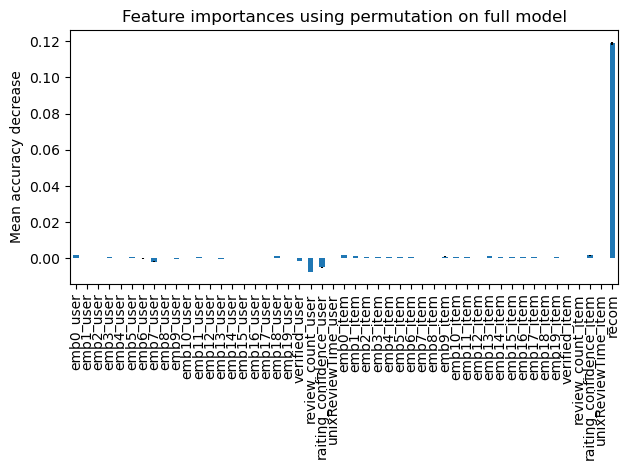

In [205]:
N_REPEATS = 10

start_time = time.time()

result = permutation_importance(
    search, X_test, y_test, n_repeats=N_REPEATS, random_state=SEED, n_jobs=-1
)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns.to_list())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

It is obseerved high importance for `recom` feature (from recomendation algorithfrom `surprise`)

### Observe results on some users/items

Results from SVDpp

In [340]:
svdpp_pred = [
    ["A2EUH5XN2FKHC3",	"B00HVQT8WW",	5.0, 4.632478,],
    ["A2EUH5XN2FKHC3",	"B0017SGUDU",	3.0,	4.237020,],
    ["A2EUH5XN2FKHC3",	"B007PPI9JC",	1.0,	3.613002,],
    ["A2EUH5XN2FKHC3",	"B005I5ML0O",	np.nan,	4.548173,],
    ["AMMU9VZZ9OSII",	"B005I5ML0O",	5.0,	4.144081,],
    ["AMMU9VZZ9OSII",	"B000VHTUKS",	3.0,	3.987568,],
    ["AMMU9VZZ9OSII",	"B002060PBQ",	2.0,	3.596234,],
    ["AMMU9VZZ9OSII",	"B007PPI9JC",	np.nan,	3.291260,],
    ["A38VV9LBC1N11Z",	"B0014VYT7O",	5.0,	4.530838,],
    ["A38VV9LBC1N11Z",	"B00T6PTQ6Y",	4.0,	4.235796,],
    ["A38VV9LBC1N11Z",	"B01CTPUQW0",	np.nan,	4.415626,],
    ["A38VV9LBC1N11Z",	"B01H1TXCJS",	np.nan,	4.415626,],
]

svdpp_pred = pd.DataFrame(svdpp_pred, columns=[USER_ID, ITEM_ID, RAITING, REC_COL])

Prepare fetures for test dataset

In [334]:
features_test = []

for user in users_test:
   user_ = X_train_user_groubed[X_train_user_groubed[USER_ID] == user].drop_duplicates()
   user_row = user_.iloc[0].to_list() if len(user_) == 1 else  list(common_user.values())
   for item in users_test[user]:
      item_ = X_train_item_grouped[X_train_item_grouped[ITEM_ID] == item].drop_duplicates()
      item_row = item_.iloc[0].to_list() if len(user_) == 1 else  list(common_item.values())
      rec = svdpp_pred.loc[(svdpp_pred[USER_ID]==user) & (svdpp_pred[ITEM_ID]==item), REC_COL]
      features_test.append(user_row + item_row + [rec])

df_features_test = pd.DataFrame(
   features_test, columns=list(X_train_user_groubed.columns) + list(X_train_item_grouped.columns) + [REC_COL])
df_features_test.drop([USER_ID, ITEM_ID], axis=1, inplace=True)

assert (df_features_test.columns == X_train.columns).all()

In [342]:
svdpp_pred.loc[:, REC_RF_COL] = search.predict(df_features_test)

c:\Users\parshin_sa2\Miniconda3\envs\otus-reso\lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


In [348]:
svdpp_pred["d_rec"] = svdpp_pred[RAITING] - svdpp_pred[REC_COL]
svdpp_pred["d_recrf"] = svdpp_pred[RAITING] - svdpp_pred[REC_RF_COL]
display(svdpp_pred)
svdpp_pred[["d_rec", "d_recrf"]].abs().mean()

,reviewerID,asin,overall,recom,recom_rf,d_rec,d_recrf
0,A2EUH5XN2FKHC3,B00HVQT8WW,5.0,4.632478,4.756355,0.367522,0.243645
1,A2EUH5XN2FKHC3,B0017SGUDU,3.0,4.237020,4.256625,-1.237020,-1.256625
2,A2EUH5XN2FKHC3,B007PPI9JC,1.0,3.613002,3.378598,-2.613002,-2.378598
3,A2EUH5XN2FKHC3,B005I5ML0O,NaN,4.548173,4.715744,NaN,NaN
4,AMMU9VZZ9OSII,B005I5ML0O,5.0,4.144081,4.103428,0.855919,0.896572
5,AMMU9VZZ9OSII,B000VHTUKS,3.0,3.987568,3.762567,-0.987568,-0.762567
6,AMMU9VZZ9OSII,B002060PBQ,2.0,3.596234,3.351885,-1.596234,-1.351885
7,AMMU9VZZ9OSII,B007PPI9JC,NaN,3.291260,3.029985,NaN,NaN
8,A38VV9LBC1N11Z,B0014VYT7O,5.0,4.530838,4.608211,0.469162,0.391789
9,A38VV9LBC1N11Z,B00T6PTQ6Y,4.0,4.235796,4.608211,-0.235796,-0.608211


d_rec      1.045278
d_recrf    0.986237
dtype: float64

<Axes: >

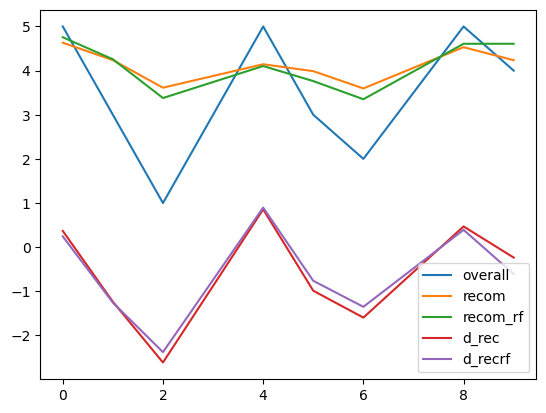

In [350]:
svdpp_pred.dropna().plot()

Observed, that predictions from `SVDpp+RF` are a `bit better`. Generally peaks are more sharper and closer to the target. Probably, for classification problem `SVDpp` and `SVDpp+RF` would have the same score.

# 8. Outcome from the whole notebook

Also add results from Surprise 

In [349]:
model_results = [
    ["SVDpp+RF", 1.2251949181639878, 0.697321407888594],
    ["SVDpp", 1.038320, 0.726963],
    ["BaselineOnly", 1.039610, 0.750934],
    ["KNNBaseline", 1.071190, 0.789666],
    ["SlopeOne", 1.092173, 0.798785],
]

models_res = pd.DataFrame(model_results, columns=["Algorithm", "RMSE", "MAE"])
models_res

,Algorithm,RMSE,MAE
0,SVDpp+RF,1.225195,0.697321
1,SVDpp,1.038320,0.726963
2,BaselineOnly,1.039610,0.750934
3,KNNBaseline,1.071190,0.789666
4,SlopeOne,1.092173,0.798785


 It is observed `SVDpp` + second algorithm (`Random Forest`) much better regarding `MAE`, but `RMSE` is worse. Supposedly because `SVDpp+RF` reacts sharper.